In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
RESULTS_LOCATION  = '../../../../data/results/'
IMG_LOCATION = '../images/'

In [3]:
class TDigestComparisonPlot(object):
    
    def __init__(self, f, plot_name=None):
        self.filename = f
        self.plot_name = plot_name
        
    def readable_name(self):
        return self.filename.rstrip('.csv').split('=')[-1]

    def _set_df(self):
        with open(RESULTS_LOCATION + self.filename, 'r') as f:
            self.df = pd.read_csv(f, header=0, sep=';')
        
    def plot_data(self, column_range=(1, -1), use_col=True, use_readable=True, plot_line=None,
                 plot_lines=None):
        self._set_df()
        # TODO: add KLL columns
        x_axis = self.df.columns[0]
        for idx, col in enumerate(self.df.columns[column_range[0]: column_range[1]]):
            if self.plot_name is not None:
                l = self.plot_name[col]
            else:
                l = ''
                if use_col is True:
                    l += col
                if use_readable is True:
                    l+= self.readable_name()
            #label = col + self.readable_name() if use_col is True else self.readable_name() 
            if plot_line is None and plot_lines is None:
                plt.plot(self.df[x_axis], self.df[col], label=l)
            elif plot_lines is None:
                plt.plot(self.df[x_axis], self.df[col], plot_line, label=l)
            else:
                plt.plot(self.df[x_axis], self.df[col], plot_lines[idx], label=l)

        #plt.plot(self.df['true quantile'][:200], self.df[self.error][:200], label=self.readable_name())
        
        

In [4]:
def display(res_files, places=0, column_range=(1,-1), imgname=None, xlabel='quantile', ylabel='error',
           use_col=True, title=None, use_readable=True, xlim=None, ylim=None,
           plot_line=None, plot_lines=None):
    """
    plot_line operates one digest results file at a time (needed when drawing columns from multiple files)
    plot_lines applies line decorations across columns in the same file
    """
    digests = [TDigestComparisonPlot(f[0], plot_name=f[1]) for f in res_files]
    for t in digests:
        if plot_lines is not None:
            t.plot_data(column_range=column_range, use_col=use_col, use_readable=use_readable, plot_lines=plot_lines)
        elif plot_line is not None:
            p = plot_line[digests.index(t)]
            t.plot_data(column_range=column_range, use_col=use_col, use_readable=use_readable, plot_line=p)
        else:
            t.plot_data(column_range=column_range, use_col=use_col, use_readable=use_readable)

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    f = lambda x : ('{:.' + str(places) + 'f}%').format(x*100) 
    plt.gca().set_yticklabels([f(x) for x in plt.gca().get_yticks()]) 
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if imgname is not None:
        plt.savefig(IMG_LOCATION + 'plot_' + imgname + '.png', dpi=300)
    plt.show()


## Analyzing the careful attack in practice






In [5]:
RESULTS_FILES = [('careful_iterations=1063_samples=204157_scalefunc=K_0_delta=500_centroids=349_sizeBytes=4220_impl=tree.csv',
                  {'TD abs. error': 'Clustering'}),
 ('careful_iterations=917_samples=1136304_scalefunc=K_0_delta=500_centroids=350_sizeBytes=5632_impl=merging_alt_true.csv',
  {'TD abs. error': 'Merging'})]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


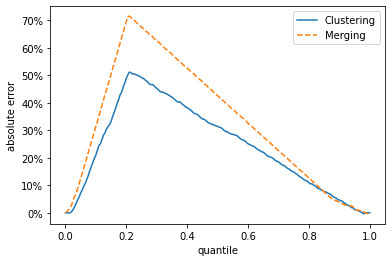

In [6]:
# Error of $t$-digest$(k_0, 500)$ on carefully constructed input

display(RESULTS_FILES, ylabel='absolute error', column_range=(1, 2), use_col=False,
        imgname='careful_input_two_digests', plot_line=['-', '--'])

## IID result 1

$t$-digest$(k_2^{glued}, 500)$ median error vs. ReqSketch $\pm 2 \sigma$

${\mathcal{D}_{\mathrm{hard}}}$ (i.e., log uniform (with square), maxExp large)




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


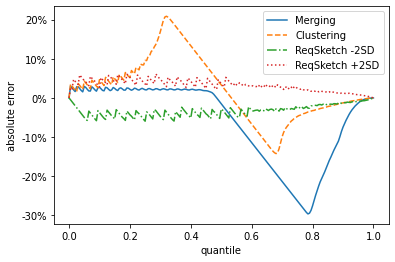

In [7]:
l_u_sq = '^iid_loguniform2_lgN=20_lgT=12__compr=500_K_2_GLUED.csv$'

#l_u_sq = '^iid_loguniform2_lgN=[0-9]*_lgT=[0-9]*__compr=500_K_2_GLUED.csv$'

sq = [x for x in os.listdir(RESULTS_LOCATION) if re.search(l_u_sq, x)]

display([(sq[0], None)],
        ylabel='absolute error', use_readable=False, imgname='D_hard',
        plot_lines=['-', '--', '-.', ':'])

## IID result 2

$t$-digest$(k_2^{glued}, 500)$ median error vs. ReqSketch $\pm 2 \sigma$

log uniform (no square), maxExp large



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


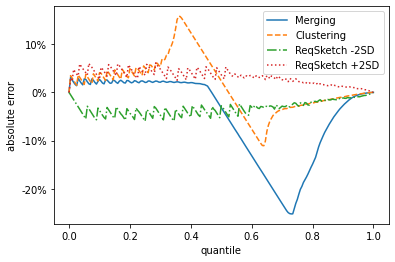

In [8]:
#l_u = '^iid_loguniform_lgN=[0-9]*_lgT=[0-9]*__compr=500_K_2_GLUED.csv$'
l_u = '^iid_loguniform_lgN=20_lgT=12__compr=500_K_2_GLUED.csv$'

base = [x for x in os.listdir(RESULTS_LOCATION) if re.search(l_u, x)]

display([(base[0], None)],
        ylabel='absolute error', use_readable=False, imgname='log_uniform',
        plot_lines=['-', '--', '-.', ':'])

## IID result 3

$t$-digest$(k_2^{glued}, 500)$ median error vs. ReqSketch $\pm 2 \sigma$

${\mathcal{D}_{\mathrm{hard}}}$ (i.e., log uniform (with square), maxExp 10)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


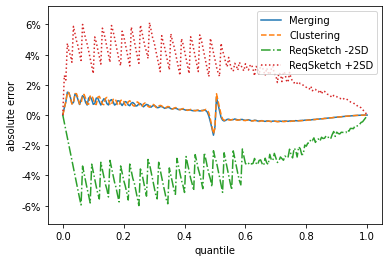

In [9]:
#l_u_sq_trunc = '^iid_loguniform2_lgN=[0-9]*_lgT=[0-9]*_maxExp=10__compr=500_K_2_GLUED.csv$'
l_u_sq_trunc = '^iid_loguniform2_lgN=20_lgT=12_maxExp=10__compr=500_K_2_GLUED.csv$'

trunc = [x for x in os.listdir(RESULTS_LOCATION) if  re.search(l_u_sq_trunc, x)]

display([(trunc[0], None)],
        ylabel='absolute error', use_readable=False, ylim=(-.072, .072), imgname='D_hard_maxExp10',
        plot_lines=['-', '--', '-.', ':'])

##### Appendix: $t$-digest results on sorted data

Sorting the same adversarial stream means the centroids should be strongly ordered, and indeed the error is much smaller when the input is presented to the $t$-digest in sorted order. Note the KLL bands are essentially the same in the scenarios above (omitted since scales disparate).

Note: these datasets will not be generated by default. They can be generated by running the `CarefulAttack` (both merging and clustering variants) with `WriteCentroidData` and `CompareToSorted` both set to `true`.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


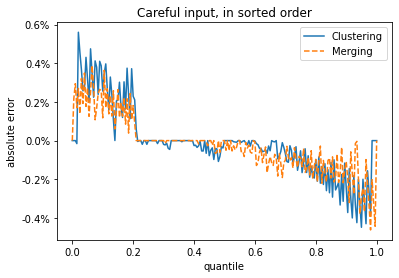

In [10]:
careful_tree_sorted = 'careful_iterations=1063_samples=204157_scalefunc=K_0_delta=500_centroids=315_sizeBytes=3812_impl=tree_sorted.csv'
careful_merging_sorted = 'careful_iterations=917_samples=1136304_scalefunc=K_0_delta=500_centroids=305_sizeBytes=4912_impl=merging_alt_true_sorted.csv'

try:
    display([(careful_tree_sorted, {'TD abs. error': 'Clustering'}),
            (careful_merging_sorted, {'TD abs. error': 'Merging'})],
            column_range=(1, 2), places=1, title='Careful input, in sorted order',
            ylabel='absolute error', use_readable=False, plot_line=['-', '--'])
except FileNotFoundError as e:
    print(e)
    print("\nYou may need to run the CarefulAttacks with WriteCentroidData=true, CompareToSorted=true as well.")